In [ ]:
# If using this on Google collab, we need to install the packages
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Let's install with dimod and neal
if IN_COLAB:
    !pip install dwave-ocean-sdk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import itertools
import networkx as nx
import matplotlib.colors as colors

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# titanic = pd.read_csv("data/formatted_titanic.csv") # To see the data folder's contents, select Jupyter File Explorer View from the Online Learning page
titanic = pd.read_csv("/content/drive/MyDrive/SJSU/CMPE-295A: Master Project I/DWave Example/data/formatted_titanic.csv")
# titanic = pd.read_csv("/content/drive/MyDrive/SJSU/CMPE-295A: Master Project I/DWave Example/data/formatted_titanic_1.csv")

# Feature Selection on a Quantum Computer

# Shanon Entropy

In [ ]:
def prob(dataset, max_bins=10):
    """Joint probability distribution P(X) for the given data."""

    # bin by the number of different values per feature
    num_rows, num_columns = dataset.shape
    bins = [min(len(np.unique(dataset[:, ci])), max_bins) for ci in range(num_columns)]

    freq, _ = np.histogramdd(dataset, bins)
    p = freq / np.sum(freq)
    return p

def shannon_entropy(p):
    """Shannon entropy H(X) is the sum of P(X)log(P(X)) for probabilty distribution P(X)."""
    p = p.flatten()
    return -sum(pi*np.log2(pi) for pi in p if pi)

In [ ]:
def conditional_shannon_entropy(p, *conditional_indices):
    """Shannon entropy of P(X) conditional on variable j"""

    axis = tuple(i for i in np.arange(len(p.shape)) if i not in conditional_indices)

    return shannon_entropy(p) - shannon_entropy(np.sum(p, axis=axis))

# Mutual Information

In [ ]:
def mutual_information(p, j):
    """Mutual information between all variables and variable j"""
    return shannon_entropy(np.sum(p, axis=j)) - conditional_shannon_entropy(p, j)

In [ ]:
def plot_mi(scores):
    if len(scores) > 5:
        plt.figure(figsize=(8, 5))
    else:
        plt.figure(figsize=(4, 4))
    labels, values = zip(*sorted(scores.items(), key=lambda pair: pair[1], reverse=True))
    plt.bar(np.arange(len(labels)), values)
    plt.xticks(np.arange(len(labels)), labels, rotation=90)
    plt.bar(np.arange(len(labels)), values)
    plt.xticks(np.arange(len(labels)), labels, rotation=90)
    plt.title("Mutual Information")
    plt.ylabel("MI with Variable of Interest")

# MIQUBO on the Predicting Survival of Titanic Passengers

In [ ]:
def conditional_mutual_information(p, j, *conditional_indices):
    """Mutual information between variables X and variable Y conditional on variable Z."""

    marginal_conditional_indices = [i-1 if i > j else i for i in conditional_indices]

    return (conditional_shannon_entropy(np.sum(p, axis=j), *marginal_conditional_indices)
            - conditional_shannon_entropy(p, j, *conditional_indices))

Plot a ranking of MI between each feature and the variable of interest (survival).

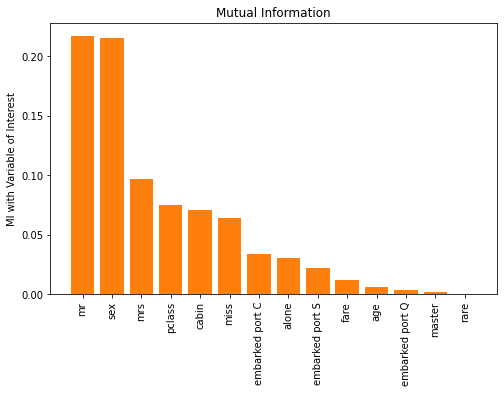

In [ ]:
mi = {}
features = list(set(titanic.columns).difference(('survived',)))

for feature in features:
    mi[feature] = mutual_information(prob(titanic[['survived', feature]].values), 1)

plot_mi(mi)

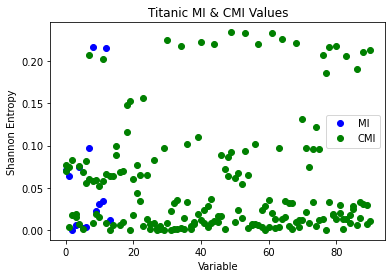

In [ ]:
plt.plot(range(len(features)), [mutual_information(prob(titanic[['survived', feature]].values), 1) for feature in features], 'bo')

plt.plot(range(len([x for x in itertools.combinations(features, 2)])), [conditional_mutual_information(prob(titanic[['survived', f0, f1]].values), 1, 2) for f0, f1 in itertools.combinations(features, 2)], 'go')
plt.plot(range(len([x for x in itertools.combinations(features, 2)])), [conditional_mutual_information(prob(titanic[['survived', f1, f0]].values), 1, 2) for f0, f1 in itertools.combinations(features, 2)], 'go')

plt.title("Titanic MI & CMI Values")
plt.ylabel("Shannon Entropy")
plt.xlabel("Variable")
plt.legend(["MI", "CMI"])

## Building the MI-Based BQM
Select 8 features with the top MI ranking found above. 

In [ ]:
keep = 8

sorted_mi = sorted(mi.items(), key=lambda pair: pair[1], reverse=True)
titanic = titanic[[column[0] for column in sorted_mi[0:keep]] + ["survived"]]
features = list(set(titanic.columns).difference(('survived',)))

print("Submitting for {} features: {}".format(keep, features))

Calculate a BQM based on the problem's MI and CMI as done previously for the toy problem.

In [ ]:
# !pip install dimod

In [ ]:
import dimod

In [ ]:
def plot_bqm(bqm):
    """Plot binary quadratic model as a labeled graph."""
    g = nx.Graph()
    g.add_nodes_from(bqm.variables)
    g.add_edges_from(bqm.quadratic)

    plt.figure(figsize=(8, 8))
    ax = plt.gca()
    ax.set_title(f"BQM with {len(bqm)} nodes and {len(bqm.quadratic)} edges")
    nx.draw_circular(g, with_labels=True, node_size=3000, node_color="y")
    plt.show()

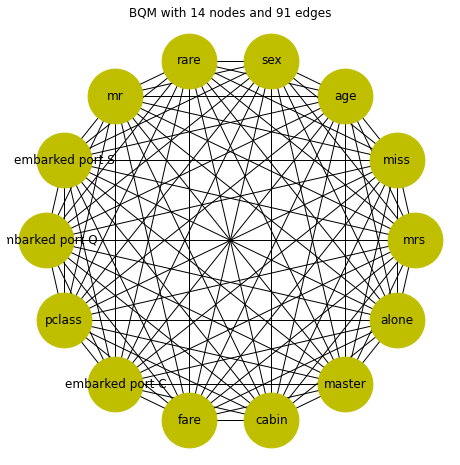

In [ ]:
# Calculate a BQM based on the problem's MI and CMI as done previously for the toy problem.

bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)

# add the features
for feature in features:
    mi = mutual_information(prob(titanic[['survived', feature]].values), 1)
    bqm.add_variable(feature, -mi)

for f0, f1 in itertools.combinations(features, 2):
    cmi_01 = conditional_mutual_information(prob(titanic[['survived', f0, f1]].values), 1, 2)
    cmi_10 = conditional_mutual_information(prob(titanic[['survived', f1, f0]].values), 1, 2)
    bqm.add_interaction(f0, f1, -cmi_01)
    bqm.add_interaction(f1, f0, -cmi_10)

bqm.normalize()  

plot_bqm(bqm)

## Setting Up a QPU as a Solver

In [ ]:
from dwave.system import DWaveSampler, FixedEmbeddingComposite
from minorminer.busclique import find_clique_embedding

endpoint = 'https://cloud.dwavesys.com/sapi'
token = 'DEV-e721167c50001a6b6abafab7487f9f13c9277aa2'
solver = 'DW_2000Q_6'

# qpu = DWaveSampler()
qpu = DWaveSampler(endpoint=endpoint, token=token, solver=solver)

qpu_working_graph = qpu.to_networkx_graph()
embedding = find_clique_embedding(bqm.variables, qpu_working_graph)
num_qubits = sum(len(chain) for chain in embedding.values())

qpu_sampler = FixedEmbeddingComposite(qpu, embedding)

print("Maximum chain length for minor embedding is {}.".format(max(len(x) for x in embedding.values())))

Maximum chain length for minor embedding is 5.


This problem is small enough to be solved in its entirety on a D-Wave 2000Q QPU. For datasets with higher numbers of features, D-Wave Ocean's [dwave-hybrid](https://docs.ocean.dwavesys.com/en/stable/docs_hybrid/sdk_index.html) tool can be used to break the BQM into smaller pieces for serial submission to the QPU and/or parallel solution on classical resources. Here, an out-of-the-box hybrid sampler, [Kerberos](https://docs.ocean.dwavesys.com/en/stable/docs_hybrid/reference/reference.html) is used.    

In [ ]:
from hybrid.reference.kerberos import KerberosSampler

kerberos_sampler = KerberosSampler() 

## Submit the Problem for All k Values

In [ ]:
def plot_feature_selection(features, selected_features):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_axes([0.1, 0.3, .9, .7])
    ax.set_title("Best Feature Selection")
    ax.set_ylabel('Number of Selected Features')
    ax.set_xticks(np.arange(len(features)))
    ax.set_xticklabels(features, rotation=90)
    ax.set_yticks(np.arange(len(features)))
    ax.set_yticklabels(np.arange(1, len(features)+1))
    # Set a grid on minor ticks
    ax.set_xticks(np.arange(-0.5, len(features)), minor=True)
    ax.set_yticks(np.arange(-0.5, len(features)), minor=True)
    ax.grid(which='minor', color='black')
    ax.imshow(selected_features, cmap=colors.ListedColormap(['white', 'red']))

In [ ]:
MAX_TIME = 500000   # limit single-problem submissions to 0.5 seconds
num_reads = 50
anneal_schedule = [[0.0, 0.0], [40.0, 0.4], [1040.0, 0.4], [1042, 1.0]]
estimated_runtime = qpu.solver.estimate_qpu_access_time(num_qubits,
   num_reads=num_reads, anneal_schedule=anneal_schedule)    
print("Estimate of {:.0f}us on {}".format(estimated_runtime, qpu.solver.name))  
# Estimate of 75005us on Advantage_system4.1

if estimated_runtime < MAX_TIME:
   qpu_sampler_min = FixedEmbeddingComposite(qpu, embedding).sample(bqm,
      num_reads=num_reads, anneal_schedule=anneal_schedule)

Estimate of 74584us on DW_2000Q_6


Submitting for k=1
Submitting for k=2
Submitting for k=3
Submitting for k=4
Submitting for k=5
Submitting for k=6
Submitting for k=7
Submitting for k=8
Submitting for k=9
Submitting for k=10
Submitting for k=11
Submitting for k=12
Submitting for k=13
Submitting for k=14


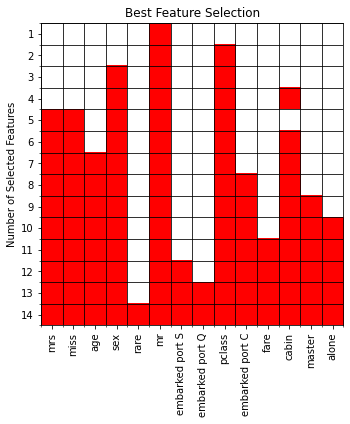

In [ ]:
selected_features = np.zeros((len(features), len(features)))
for k in range(1, len(features) + 1):
    print("Submitting for k={}".format(k))
    kbqm = dimod.generators.combinations(features, k, strength=6)
    kbqm.update(bqm)
    kbqm.normalize()
    
    best = kerberos_sampler.sample(kbqm, 
                                   qpu_sampler=qpu_sampler, 
                                   qpu_reads=1000, 
                                   max_iter=10,
                                   qpu_params={'label': 'Notebook - Feature Selection'}
                                  ).first.sample
    
    for fi, f in enumerate(features):
        selected_features[k-1, fi] = best[f]

plot_feature_selection(features, selected_features)

In [ ]:
keysList = list(best.keys())
print(keysList)

['age', 'alone', 'cabin', 'embarked port C', 'embarked port Q', 'embarked port S', 'fare', 'master', 'miss', 'mr', 'mrs', 'pclass', 'rare', 'sex']


In [ ]:
best_pd = titanic[keysList]

In [ ]:
best_pd

age  alone  cabin  embarked port C  embarked port Q  embarked port S  \
0       2   True   True            False            False             True   
1       0  False   True            False            False             True   
2       0  False   True            False            False             True   
3       2  False   True            False            False             True   
4       2  False   True            False            False             True   
...   ...    ...    ...              ...              ...              ...   
1040    4   True  False             True            False            False   
1041    0  False  False             True            False            False   
1042    2   True  False             True            False            False   
1043    2   True  False             True            False            False   
1044    2   True  False            False            False             True   

      fare  master   miss     mr    mrs  pclass   rare  sex  
0        2   False   True  False  False       1  False    1  
1        1    True  False  False  False       1  False    0  
2        1   False   True  False  False       1  False    1  
3        1   False  False   True  False       1  False    0  
4        1   False  False  False   True       1  False    1  
...    ...     ...    ...    ...    ...     ...    ...  ...  
1040     0   False  False   True  False       3  False    0  
1041     0   False   True  False  False       3  False    1  
1042     0   False  False   True  False       3  False    0  
1043     0   False  False   True  False       3  False    0  
1044     0   False  False   True  False       3  False    0  

[1045 rows x 14 columns]

# ML Model API

### ML Model API Example (from the slide "API Spec..pptx")
<pre>
API Name: quantum_feature_selection, classical_feature_selection
Input: Dataset w/o feature selection  (Pandas Dataframe)
Output: Dataset w/ feature selection  (Pandas Dataframe)

def quantum_feature_selection(input_training_dataset_pd, input_testing_dataset_pd):
	model = train_machine_learning_process(input_training_dataset_pd)
	output_accuracy_float = model(input_testing_dataset_pd)
	return output_accuracy_float
</pre>

# Feature Selection API

In [ ]:
# !pip install dwave-ocean-sdk
# !pip install dimod

In [1]:
# from helpers.plots import plot_toy_signals
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import itertools
import networkx as nx
import matplotlib.colors as colors
import dimod
from dwave.system import DWaveSampler, FixedEmbeddingComposite
from minorminer.busclique import find_clique_embedding
from hybrid.reference.kerberos import KerberosSampler

## Get dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv("/content/drive/MyDrive/SJSU/CMPE-295A: Master Project I/DWave Example/data/formatted_titanic.csv")

In [4]:
def prob(dataset, max_bins=10):
    """Joint probability distribution P(X) for the given data."""

    # bin by the number of different values per feature
    num_rows, num_columns = dataset.shape
    bins = [min(len(np.unique(dataset[:, ci])), max_bins) for ci in range(num_columns)]

    freq, _ = np.histogramdd(dataset, bins)
    p = freq / np.sum(freq)
    return p

def shannon_entropy(p):
    """Shannon entropy H(X) is the sum of P(X)log(P(X)) for probabilty distribution P(X)."""
    p = p.flatten()
    return -sum(pi*np.log2(pi) for pi in p if pi)

def conditional_shannon_entropy(p, *conditional_indices):
    """Shannon entropy of P(X) conditional on variable j"""

    axis = tuple(i for i in np.arange(len(p.shape)) if i not in conditional_indices)

    return shannon_entropy(p) - shannon_entropy(np.sum(p, axis=axis))

def mutual_information(p, j):
    """Mutual information between all variables and variable j"""
    return shannon_entropy(np.sum(p, axis=j)) - conditional_shannon_entropy(p, j)
    
def conditional_mutual_information(p, j, *conditional_indices):
    """Mutual information between variables X and variable Y conditional on variable Z."""

    marginal_conditional_indices = [i-1 if i > j else i for i in conditional_indices]

    return (conditional_shannon_entropy(np.sum(p, axis=j), *marginal_conditional_indices)
            - conditional_shannon_entropy(p, j, *conditional_indices))

    
def classical_MI(df, label):

  # label = 'survived' # label for mutual information interest
  mi = {}
  features = list(set(df.columns).difference((label,)))

  for feature in features:
    mi[feature] = mutual_information(prob(df[[label, feature]].values), 1)

  # Select 8 features with the top MI ranking found above. 
  keep = 8

  sorted_mi = sorted(mi.items(), key=lambda pair: pair[1], reverse=True)
  df = df[[column[0] for column in sorted_mi[0:keep]] + [label]]
  features = list(set(df.columns).difference((label,)))

  # print("Submitting for {} features: {}".format(keep, features))

  return df[features]


def MIQUBO(df, label):

  # label = 'survived' # label for mutual information interest
  mi = {}
  features = list(set(df.columns).difference((label,)))

  for feature in features:
    mi[feature] = mutual_information(prob(df[[label, feature]].values), 1)

  # Select 8 features with the top MI ranking found above. 
  keep = 8

  sorted_mi = sorted(mi.items(), key=lambda pair: pair[1], reverse=True)
  df = df[[column[0] for column in sorted_mi[0:keep]] + [label]]
  features = list(set(df.columns).difference((label,)))

  # Calculate a BQM based on the problem's MI and CMI as done previously for the toy problem.

  bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)

  # add the features
  for feature in features:
    mi = mutual_information(prob(df[['survived', feature]].values), 1)
    bqm.add_variable(feature, -mi)

  for f0, f1 in itertools.combinations(features, 2):
    cmi_01 = conditional_mutual_information(prob(df[['survived', f0, f1]].values), 1, 2)
    cmi_10 = conditional_mutual_information(prob(df[['survived', f1, f0]].values), 1, 2)
    bqm.add_interaction(f0, f1, -cmi_01)
    bqm.add_interaction(f1, f0, -cmi_10)

  bqm.normalize()
  
  endpoint = 'https://cloud.dwavesys.com/sapi'
  token = 'DEV-8ee4cb649cb2e3809607fce6c1f620cd8cd5918f'
  solver = 'DW_2000Q_6'

  # qpu = DWaveSampler()
  qpu = DWaveSampler(endpoint=endpoint, token=token, solver=solver)

  qpu_working_graph = qpu.to_networkx_graph()
  embedding = find_clique_embedding(bqm.variables, qpu_working_graph)
  num_qubits = sum(len(chain) for chain in embedding.values())

  qpu_sampler = FixedEmbeddingComposite(qpu, embedding)

  kerberos_sampler = KerberosSampler() 

  MAX_TIME = 500000   # limit single-problem submissions to 0.5 seconds
  num_reads = 50
  anneal_schedule = [[0.0, 0.0], [40.0, 0.4], [1040.0, 0.4], [1042, 1.0]]
  estimated_runtime = qpu.solver.estimate_qpu_access_time(num_qubits,
    num_reads=num_reads, anneal_schedule=anneal_schedule)    
  # print("Estimate of {:.0f}us on {}".format(estimated_runtime, qpu.solver.name))  
  # Estimate of 75005us on Advantage_system4.1

  if estimated_runtime < MAX_TIME:
    qpu_sampler_min = FixedEmbeddingComposite(qpu, embedding).sample(bqm,
        num_reads=num_reads, anneal_schedule=anneal_schedule)
  
  selected_features = np.zeros((len(features), len(features)))
  for k in range(1, len(features) + 1):
    # print("Submitting for k={}".format(k))
    kbqm = dimod.generators.combinations(features, k, strength=6)
    kbqm.update(bqm)
    kbqm.normalize()
    
    best = kerberos_sampler.sample(kbqm, 
                                   qpu_sampler=qpu_sampler, 
                                   qpu_reads=1000, 
                                   max_iter=10,
                                   qpu_params={'label': 'Notebook - Feature Selection'}
                                  ).first.sample
    
  for fi, f in enumerate(features):
    selected_features[k-1, fi] = best[f]

  keysList = list(best.keys())
  best_pd = df[keysList]

  return best_pd
    

########## Feature Selection API ##################################################

def quantum_feature_selection(input_dataset_pd, label):
  """ 
  :quantum_feature_selection
  :param input_dataset_pd: Dataset without Feature Selection
  :param label: label for mutual information interest
  :return: df_feature_selected
  """
  df_feature_selected = MIQUBO(input_dataset_pd, label)
  return df_feature_selected

def classical_feature_selection(input_dataset_pd, label):
  """ 
  :classical_feature_selection
  :param input_dataset_pd: Dataset without Feature Selection
  :param label: label for mutual information interest
  :return: df_feature_selected
  """
  df_feature_selected = classical_MI(input_dataset_pd, label)
  return df_feature_selected

# Testing

In [5]:
best1 = quantum_feature_selection(data, "survived")

In [6]:
best1

alone  cabin  embarked port C   miss     mr    mrs  pclass  sex
0      True   True            False   True  False  False       1    1
1     False   True            False  False  False  False       1    0
2     False   True            False   True  False  False       1    1
3     False   True            False  False   True  False       1    0
4     False   True            False  False  False   True       1    1
...     ...    ...              ...    ...    ...    ...     ...  ...
1040   True  False             True  False   True  False       3    0
1041  False  False             True   True  False  False       3    1
1042   True  False             True  False   True  False       3    0
1043   True  False             True  False   True  False       3    0
1044   True  False            False  False   True  False       3    0

[1045 rows x 8 columns]

In [7]:
best2 = classical_feature_selection(data, "survived")

In [8]:
best2

cabin   miss     mr  pclass  sex    mrs  embarked port C  alone
0      True   True  False       1    1  False            False   True
1      True  False  False       1    0  False            False  False
2      True   True  False       1    1  False            False  False
3      True  False   True       1    0  False            False  False
4      True  False  False       1    1   True            False  False
...     ...    ...    ...     ...  ...    ...              ...    ...
1040  False  False   True       3    0  False             True   True
1041  False   True  False       3    1  False             True  False
1042  False  False   True       3    0  False             True   True
1043  False  False   True       3    0  False             True   True
1044  False  False   True       3    0  False            False   True

[1045 rows x 8 columns]

# Reference:

1. [D-Wave Feature Selection example](https://green-kangaroo-0bqmh1vu.ws.ide.dwavesys.io/)